In [1]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
import pickle
import matplotlib.pyplot as plt

In [2]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [284]:
# alt distance
mlong = pd.read_csv('../data/joined.csv', index_col='apn')
mlong['nf'] = mlong['nf'].apply(eval)
def jaccard(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2)

# good old panda based distance calculation:
distance = lambda x,y: jaccard(x, y, mlong['nf'])

In [77]:
net_file_name = '../res/streamed_nets.pickle' #'../res/distances.new2_merged.pickle'
print(f"Reading in nets from {net_file_name}")
with open(net_file_name, 'rb') as f:
    allthenet = pickle.load(f)

Reading in nets from ../res/streamed_nets.pickle


In [7]:
def get_outliers(net, gamma):
    outl = list()
    for an, agg in net.items():
        if not agg:
            continue
        th = [(an, a, distance(a, an)) for a in agg]# if distance(a, an)> gamma]
        outl = outl + th
    return outl


In [8]:
res = dict()
for gamma, net in tqdm(allthenet.items()):
    res[gamma] = get_outliers(net, gamma)

  0%|          | 0/19 [00:00<?, ?it/s]

## Check if the network is well-made
The aggregated apps should be in the closest anchors

In [78]:
gamma = 0.5
anet = allthenet[gamma]
dsts = res[gamma]

for (an, apk, d) in tqdm(dsts):
    dia = [(b, distance(apk, b)) for b in anet.keys() if (distance(apk, b)<d) & (b!=an)]
    if dia:
        print(an, apk, dia)

  0%|          | 0/8467 [00:00<?, ?it/s]

16393 26000 [(2211, 0.4285714285714286), (21306, 0.4)]
16393 18788 [(29, 0.19999999999999996)]


KeyboardInterrupt: 

In [9]:
gamma = 0.5
anet = allthenet[gamma]

In [79]:
for k, v in tqdm(anet.items()):
    for vi in v:
        curr_dist = distance(vi, k)
        distances = [(vi, ki, distance(vi, ki),k, curr_dist) for ki in anet.keys() if distance(vi,ki)<curr_dist]
        if distances:
            print(distances)
    

  0%|          | 0/536 [00:00<?, ?it/s]

[(26000, 2211, 16393, 0.4285714285714286, 0.5), (26000, 21306, 16393, 0.4, 0.5)]
[(18788, 29, 16393, 0.19999999999999996, 0.5)]


KeyboardInterrupt: 

In [11]:
#[(18788, 29, 16393, 0.19999999999999996, 0.5)]
#(vi, ki, k, distance(vi, ki), curr_dist)

In [15]:
18788 in anet[16393], 29 in anet

(True, True)

In [16]:
distance(18788, 16393), distance(18788, 29)

(0.5, 0.19999999999999996)

In [22]:
def tc_based_nn(net, apks, data):
    anch = list(net.keys())
    anch.extend(apks)
    allt = data.filter_by(values=anch, column_name='apk')

    m = len(anch)
    sim_recom = tc.item_similarity_recommender.create(
        allt, 
        user_id='function', 
        item_id='apk', 
        similarity_type='jaccard', 
        degree_approximation_threshold=15*4096,
        only_top_k=m, verbose=False)
    
    # smaller k could be an optimization here
    items =sim_recom.get_similar_items(apks, k=m)
    # recomendations excluding similarity between apks
    fitems = items.filter_by(values=apks, column_name='similar', exclude=True)
    fitems['distance'] = 1.0 - fitems['score']
    
    return fitems #fitems.groupby(key_column_names=['apk'], operations={'nn': tc.aggregate.ARGMAX('score', 'similar')})




In [60]:
vals = list()
for k,v in anet.items():
    vals = vals + v
    
print(len(vals))

8467


In [61]:
r = tc_based_nn(net=anet, apks=vals, data=mw)

In [62]:
gwrr = r.groupby(key_column_names=['apk'], 
          operations={'nn': tc.aggregate.ARGMIN('distance', 'similar'), 
                      'distan': tc.aggregate.ARGMIN('distance', 'distance')})
#r

In [63]:
gwrr[gwrr['apk']==18788]

apk,nn,distan
18788,29,0.19999998807907104


In [64]:
gwrrd = r.groupby(key_column_names=['apk'], 
          operations={'nn': tc.aggregate.ARGMAX('score', 'similar'), 
                      'sim': tc.aggregate.ARGMAX('score', 'score')})


In [65]:
gwrrd[gwrrd['apk']==18788]

apk,nn,sim
18788,29,0.800000011920929


In [66]:
18788 in anet[29]

False

In [67]:
gwrr.groupby(key_column_names='nn', operations={'nodes': agg.DISTINCT('apk')})
#true_dicts = [{row['nn']: row['nodes'] for row in nep} for nep in dicts]

nn,nodes
8324,"[1334, 279, 6575, 10975,12783, 14588, 14925, ..."
15635,"[15227, 1249, 25087,14471] ..."
14897,"[19737, 11561, 2954,19306, 13836, 18025] ..."
11338,"[11509, 6835]"
18638,"[18569, 16446, 9867]"
25885,"[596, 21196, 9974]"
6314,"[26198, 5551, 2363,15910, 26494, 13362, ..."
19581,"[18994, 9405, 1078,13316, 18712, 3685, ..."
2211,"[24284, 22838, 7304,24787, 5127, 6213, 5319, ..."
25650,"[7071, 23743, 25856,25900, 13255, 9151, ..."


In [68]:
mazza = gwrrd.groupby(key_column_names='nn', operations={'nodes': agg.DISTINCT('apk')})

In [69]:
nnet = {row['nn']: row['nodes'] for row in mazza}

In [71]:
len(nnet), len(anet)

(457, 536)

In [73]:
sum(map(len, anet.values())), sum(map(len, nnet.values()))

(8467, 8467)

In [74]:
for k, v in tqdm(nnet.items()):
    for vi in v:
        curr_dist = distance(vi, k)
        distances = [(vi, ki, k, distance(vi, ki), curr_dist) for ki in nnet.keys() if distance(vi,ki)<curr_dist]
        if distances:
            print(distances)
    

  0%|          | 0/457 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [80]:
from grapm import partition_ndframe

In [81]:
subsamp = mw
napks = subsamp['apk'].unique().to_numpy()

In [82]:
test_size = 1000
train, test = train_test_split(napks, test_size=test_size, random_state=42)
#np.save(f"../res/test-tc-{test_size}", test)

parts = partition_ndframe(nd=train, n_parts=4)

In [90]:
# so this is not a problem with origin network calcluation
18788 in parts[0], 29 in parts[0], 16393 in parts[0]

(False, False, True)

In [94]:
# but where this comes from then:
29 in anet.keys(), 16393 in anet.keys(), 18788 in anet.keys()

(True, True, False)

In [87]:
#[(18788, 29, 16393, 0.19999999999999996, 0.5)]

In [88]:
sparts = [subsamp.filter_by(values=part, column_name='apk') for part in parts]

In [100]:
with open('/tmp/p1.txt', 'wb+') as f:
    np.savetxt(f, parts[0], fmt='%d')

In [99]:
np.savetxt?

In [101]:
# original network
# apparently seting same seeds is not enough for reproducibility

In [104]:
fname = '../res/0.5-stream-singleaggregating.pickle'

In [105]:
with open(fname, 'rb') as f:
    ann = pickle.load(f)

In [107]:
ann = ann[0.5]

In [110]:
[true_dicts, origin_net] = ann

In [113]:
# but where this comes from then:
29 in origin_net.keys(), 16393 in origin_net.keys(), 18788 in origin_net.keys(), 18788 in origin_net[16393]

(True, True, False, True)

In [114]:
# problem in the origin network (apk=18788) should be with anchor 29 is with 16393
distance(29, 18788), distance(16393, 18788)

(0.19999999999999996, 0.5)

In [115]:

for k, v in tqdm(origin_net.items()):
    for vi in v:
        curr_dist = distance(vi, k)
        distances = [(vi, ki, distance(vi, ki),k, curr_dist) for ki in origin_net.keys() if distance(vi,ki)<curr_dist]
        if distances:
            print(distances)
    

  0%|          | 0/536 [00:00<?, ?it/s]

[(18788, 29, 0.19999999999999996, 16393, 0.5)]
[(26000, 2211, 0.4285714285714286, 16393, 0.5), (26000, 21306, 0.4, 16393, 0.5)]
[(15619, 3721, 0.45201041732833636, 4109, 0.4907125752378487), (15619, 19718, 0.41996204933586334, 4109, 0.4907125752378487), (15619, 5806, 0.4526655422746938, 4109, 0.4907125752378487)]
[(18533, 19718, 0.4173242153252674, 4109, 0.49502123297700984)]
[(11942, 8221, 0.3254882930971733, 4109, 0.49934428758774974), (11942, 19718, 0.4603506222181851, 4109, 0.49934428758774974)]
[(8364, 8221, 0.32863564572955895, 4109, 0.4526391325147504)]
[(5585, 3721, 0.46233917372470423, 4109, 0.4834556370913943), (5585, 19718, 0.3696002578981302, 4109, 0.4834556370913943)]
[(12020, 8221, 0.32483302975106254, 4109, 0.4989192527404662), (12020, 19718, 0.46135682499318864, 4109, 0.4989192527404662)]
[(9911, 3721, 0.46796589524969545, 4109, 0.47517237016889113), (9911, 19718, 0.3883169203222918, 4109, 0.47517237016889113)]
[(7868, 19718, 0.36926082709215236, 4109, 0.424896903613615

KeyboardInterrupt: 

In [118]:
with open('../res/p0.txt', 'r') as f:
    p0=np.loadtxt(f)
    
spart = mw.filter_by(values=list(map(int, p0)), column_name='apk')

In [119]:
p0

array([13929.,  3852.,  1352., ..., 17326.,  9722., 20043.])

In [121]:
29 in p0, 18788 in p0, 16393 in p0

(True, True, True)

In [122]:
from grapm import f_create_network

In [127]:
spart = mw.filter_by(values=list(map(int, p0)), column_name='apk')
#f_create_network()

In [128]:
locnet = f_create_network(data=spart, gamma=0.5)

In [130]:
29 in locnet.keys(), 18788 in locnet.keys(), 16393 in locnet.keys()

(True, False, True)

In [133]:
18788 in locnet[29], 18788 in locnet[16393]

(False, True)

In [135]:
distance(18788, 29), distance(18788, 16393), distance(29, 16393)

(0.19999999999999996, 0.5, 0.6)

In [138]:
def pn(data, gamma):
    apks = data['apk'].unique()
    k = apks.shape[0]
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k, 
                                                      degree_approximation_threshold=15*4096, 
                                                      threshold=0.0, verbose=False)
    itms = sim_recom.get_similar_items(apks, k=k)
    # missing more "distant nodes", "not aggregating nodes"
    gw=itms[itms['score']>=1-gamma].groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})
    return gw, itms

In [228]:
itms.head()

apk,similar,score,rank,distance
5783,24234,1.0,1,0.0
5783,10602,1.0,2,0.0
5783,6939,0.688034176826477,3,0.31196582317352295
5783,21088,0.6363636255264282,4,0.3636363744735718
5783,27647,0.5735294222831726,5,0.4264705777168274
5783,15935,0.016949176788330078,6,0.9830508232116699
5783,24095,0.016483545303344727,7,0.9835164546966553
5783,16668,0.01592355966567993,8,0.9840764403343201
5783,1820,0.015118777751922607,9,0.9848812222480774
5783,2388,0.014836788177490234,10,0.9851632118225098


In [151]:
18788 in gw[gw['apk']==29]['sims'][0]

True

In [152]:
18788 in gw[gw['apk']==16393]['sims'][0]

True

In [ ]:
# this is probably the problem apk=18788 is closer than gamma to both potential anchors (29 and 16393)

In [ ]:
ws = set(gw['apk'])
    net = dict()
    already_added = set()
    while len(ws)>0:
        w= ws.pop()

        simp = set(gw[gw['apk']==w]['sims'][0])
        simp = simp - already_added

        net[w] = list(simp)
        already_added.update(simp)
        already_added.add(w)

        ws = ws - simp

In [139]:
gw, itms = pn(data=spart, gamma=0.5)

In [141]:
itms['distance'] = 1.0 - itms['score']

In [145]:
itms[(itms['apk']==29)&(itms['similar']==18788)]

apk,similar,score,rank,distance
29,18788,0.800000011920929,130,0.19999998807907104


In [146]:
itms[(itms['apk']==16393)&(itms['similar']==18788)]

apk,similar,score,rank,distance
16393,18788,0.5,377,0.5


In [208]:

def create_aggregating_net(gamma: float, apns, distance):
    net = dict()

    for a in apns:
        insert = True
        for n in net.keys():
            # this is actually wrong, just because distance < gamma, does not mean that this is the closest anchor
            if distance(a, n) <= gamma:
                insert = False
                net[n].append(a)
                break  
        if insert:
            net[a] = list()

    return net


def create_aggregating_net2(gamma: float, apns, distance):
    net = dict()
    non_anchors = list()
    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) <= gamma:
                insert = False
                non_anchors.append(a)
                break  
        if insert:
            net[a] = list()

    for na in non_anchors:
        byd = sorted(net.keys(), key=lambda x: distance(x, na))
        #print(byd)
        net[byd[0]].append(na)
        
            
    return net


In [156]:

def d(p1, p2) -> float:
    v = [(x-y)**2 for x,y in zip(p1, p2)]
    return np.sqrt(sum(v))

In [157]:
from sklearn.datasets import make_blobs

num_points = 50
centers = [[1, 1], [-1, -1]]
X, y = make_blobs(n_samples=num_points, centers=centers, n_features=2, cluster_std=0.8, random_state=42)

points = list(zip(X[:, 0], X[:, 1]))
labels=y

In [209]:
net = create_aggregating_net(gamma=1.5, apns = list(zip(X[:, 0], X[:, 1])), distance=d)
net2 = create_aggregating_net2(gamma=1.5, apns=list(zip(X[:, 0], X[:, 1])), distance=d)

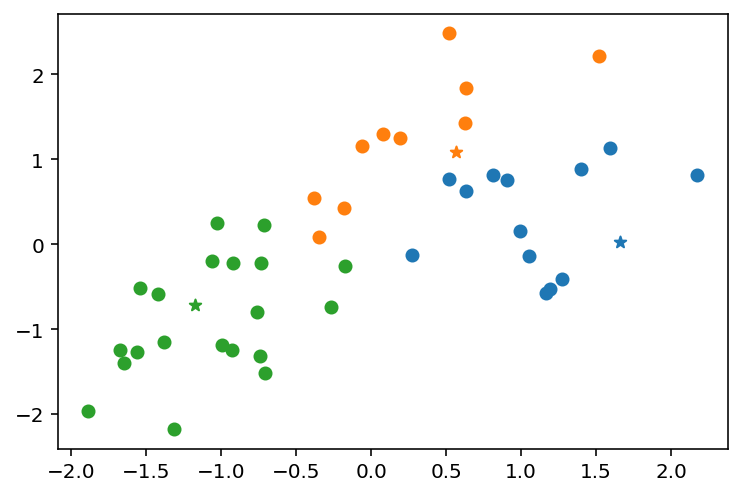

In [198]:

for k, v in net.items():
    if any(v):
        pc = plt.scatter(k[0], k[1], marker='*')
        x, y =list(zip(*v))
        plt.scatter(x, y, facecolor=pc.get_edgecolor())

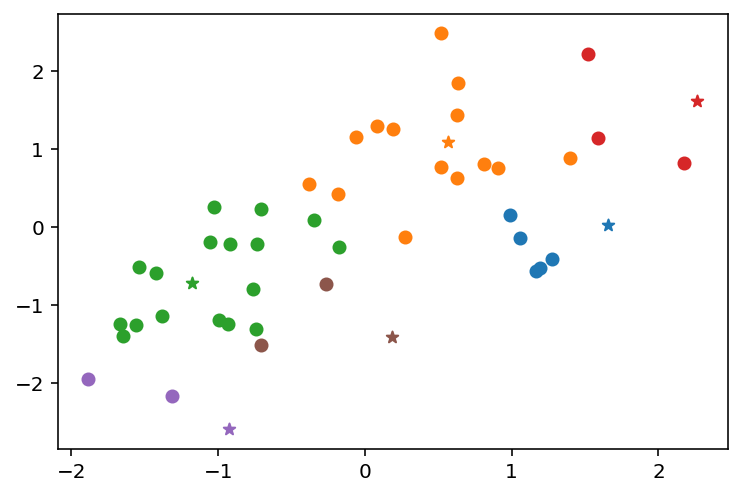

In [225]:

for k, v in net2.items():
    if any(v):
        pc = plt.scatter(k[0], k[1], marker='*')
        x, y =list(zip(*v))
        plt.scatter(x, y, facecolor=pc.get_edgecolor())


In [226]:
# FIxing it for tc-based solution

In [254]:
with open('../res/p0.txt', 'r') as f:
    p0=np.loadtxt(f, dtype=int)
    
spart = mw.filter_by(values=list(map(int, p0)), column_name='apk')

In [338]:
def get_anchors(data, gamma):
    apks = data['apk'].unique()
    k = apks.shape[0]
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k, 
                                                      degree_approximation_threshold=15*4096, 
                                                      threshold=0.0, verbose=False)
    itms = sim_recom.get_similar_items(apks, k=k)
    # missing more "distant nodes", "not aggregating nodes"
    # setup a list in form: apk [apk1, apk2,...]
    # all aggregated items will be closer than given radius, ie, they are def. not anchors
    # the list will be used to build network in a greedy way
    gw=itms[itms['score']>=1-gamma].groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})
    
    ws = set(gw['apk'])
    anchors = list()
    already_added = set()
    # greedy building net
    # start with first row apk1, [apk2, apk3, apk4...], 
    # apk1 is added to network, 
    # remove all apks that are closer than radius (ie. all from the list) from the following rows
    while len(ws)>0:
        w= ws.pop()
        anchors.append(w)

        # all apks closer than given radius to this anchors
        simp = set(gw[gw['apk']==w]['sims'][0])
        simp = simp - already_added
            
        already_added.update(simp)
        already_added.add(w)

        # remove its aggregates 
        ws = ws - simp
    
    # move to nodes pairs that are at distance > radius
    # there should be no close nodes to that one, otherwise they
    # would appear in the previous loop
    if len(already_added)> 0:
        nds = apks.filter_by(list(already_added), exclude=True)
        
    # special case for gamma=0
    else:
        nds = apks
        
    
    anchors = anchors + list(nds)
        
    return anchors


In [339]:
nn = new_f_create_network(data=spart, gamma=.5)

In [341]:
len(nn)

536

In [238]:
# check if there are not anchors closer to each other than gamma=0.5


In [342]:
anchor_data = mw.filter_by(column_name='apk', values=nn)

In [343]:
sim_recom = tc.item_similarity_recommender.create(anchor_data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=10000, 
                                                      degree_approximation_threshold=15*4096, 
                                                      threshold=0.0, verbose=False)


In [344]:
itms = sim_recom.get_similar_items(nn, k=10000)

In [345]:
itms['distance'] = 1.0 - itms['score']

In [346]:
itms[itms['distance']<.5]

apk,similar,score,rank,distance


In [247]:
# check if there are not apks farther than gamma
# perform nn on the anchros if nn is > gamma it should have been an anchor

In [347]:
apks = [a for a in p0 if a not in nn]

In [348]:
len(apks), len(nn), len(p0)

(1715, 536, 2251)

In [349]:
#anch = nn.copy()x
#anch.extend(apks)
#allt = data.filter_by(values=anch, column_name='apk')

m = len(p0)
sim_recom = tc.item_similarity_recommender.create(
    spart, 
    user_id='function', 
    item_id='apk', 
    similarity_type='jaccard', 
    degree_approximation_threshold=15*4096,
    only_top_k=m, verbose=False)

# smaller k could be an optimization here
items =sim_recom.get_similar_items(apks, k=m)
# recomendations excluding similarity between apks
fitems = items.filter_by(values=apks, column_name='similar', exclude=True)
fitems['distance'] = 1.0 - fitems['score']


In [350]:
gwrr = fitems.groupby(key_column_names=['apk'], 
          operations={'nn': tc.aggregate.ARGMIN('distance', 'similar'), 
                      'distan': tc.aggregate.ARGMIN('distance', 'distance')})


In [355]:
gwrr

apk,nn,distan
5783,21088,0.3636363744735718
11106,16507,0.002100825309753418
1517,12897,0.0009049773216247559
25944,13131,0.3333333134651184
11120,15412,0.006268739700317383
8272,4104,0.1937071681022644
23845,16393,0.0
14153,16393,0.0
6380,661,0.19860142469406128
21355,21522,0.0


In [351]:
gwrr[gwrr['distan']>0.5]

apk,nn,distan


In [354]:
gwrr

apk,nn,distan
5783,21088,0.3636363744735718
11106,16507,0.002100825309753418
1517,12897,0.0009049773216247559
25944,13131,0.3333333134651184
11120,15412,0.006268739700317383
8272,4104,0.1937071681022644
23845,16393,0.0
14153,16393,0.0
6380,661,0.19860142469406128
21355,21522,0.0


In [422]:
#all in one:
def all_in_one_tc(data, gamma):
    apks = data['apk'].unique()
    k = apks.shape[0]
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k, 
                                                      degree_approximation_threshold=15*4096, 
                                                      threshold=0.0, verbose=False)
    itms = sim_recom.get_similar_items(apks, k=k)
    # missing more "distant nodes", "not aggregating nodes"
    # setup a list in form: apk [apk1, apk2,...]
    # all aggregated items will be closer than given radius, ie, they are def. not anchors
    # the list will be used to build network in a greedy way
    gw=itms[itms['score']>=1-gamma].groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})
    
    ws = set(gw['apk'])
    anchors = list()
    already_added = set()
    # greedy building net
    # start with first row apk1, [apk2, apk3, apk4...], 
    # apk1 is added to network, 
    # remove all apks that are closer than radius (ie. all from the list) from the following rows
    while len(ws)>0:
        w= ws.pop()
        anchors.append(w)

        # all apks closer than given radius to this anchors
        simp = set(gw[gw['apk']==w]['sims'][0])
        simp = simp - already_added
            
        already_added.update(simp)
        already_added.add(w)

        # remove its aggregates 
        ws = ws - simp
    
    # move to nodes pairs that are at distance > radius
    # there should be no close nodes to that one, otherwise they
    # would appear in the previous loop
    if len(already_added)> 0:
        nds = apks.filter_by(list(already_added), exclude=True)
        
    # special case for gamma=0
    else:
        nds = apks
        
    
    anchors = anchors + list(nds)
    
    #following is equivallent to NN search on just created anchors:
    # done here to reuse existing recommender
    
    # recomendations excluding similarity between apks
    fitems = itms.filter_by(values=anchors, column_name='apk',exclude=True).filter_by(values=anchors,column_name='similar')
    
    gwrrd = fitems.groupby(key_column_names=['apk'], operations={'nn': tc.aggregate.ARGMAX('score', 'similar')})
    r = gwrrd.groupby(key_column_names=['nn'], operations={'aggregates': agg.DISTINCT('apk')})
    net = r.to_dataframe().set_index('nn').to_dict(orient='dict')['aggregates']

    # not used anchors added:
    net.update({an:[] for an in anchors if an not in net})
    return net

In [423]:
net = all_in_one_tc(data=spart, gamma=0.5)

In [424]:
# some checks:

In [425]:
# is all data added:
sum(map(len, net.values())) + len(net), len(p0)

(2251, 2251)

In [426]:
# check if aggregates are close to thier anchors:
gamma = 0.5
for k,v in net.items():
    for vi in v:
        if distance(vi,k)>gamma:
            print("Wrong assignment {k} {vi}")

In [427]:
# check anchor distances:
nk = list(net.keys())
for i,e in enumerate(nk):
    for f in nk[i+1:]:
        if distance(e,f)<gamma:
            print("Wrong anchors {e} {f}")

In [433]:
# check if there is closer anchor:
def closers(net):
    nk = list(net.keys())
    for k,v in tqdm(net.items()):
        for vi in v:
            for k2 in nk:
                if k2==k:
                    continue
                if distance(vi, k2)<distance(vi, k):
                    print(f"Wrong attachement: {vi}-{k} should be {k2}")

In [430]:
with open("../res/newres/0.25-stream-singleaggregating.pickle", 'rb') as f:
    anet = pickle.load(f)

[true_dicts, origin_net] = anet[0.25]

In [434]:
closers(net=origin_net)

  0%|          | 0/759 [00:00<?, ?it/s]

In [435]:
len(true_dicts)

3

In [439]:
closers(net=true_dicts[0])

  0%|          | 0/453 [00:00<?, ?it/s]

In [440]:
closers(net=true_dicts[1])

  0%|          | 0/454 [00:00<?, ?it/s]

In [446]:
# already for eps =0.0 we have seen distance = 1.0
def load_nets(gamma = 0.0):
    with open(f"../res/newres/{gamma}-stream-singleaggregating.pickle", 'rb') as f:
        anet = pickle.load(f)

    return anet[gamma]

In [447]:
[td, n] = load_nets(0.2)

In [458]:
def get_dds(n):
    res = dict()
    for anchor, k in tqdm(n.items()):
        if any(k):
            res[anchor] = [distance(anchor, v) for v in k]
    return res

In [ ]:
# network distances looks perfect (nothing > eps)

In [455]:
maxes = {gamma: max(v) for gamma, v in res.items()}
dict(sorted(maxes.items(), key=lambda x: x[1], reverse=True))

{29: 0.19999999999999996,
 14541: 0.19999999999999996,
 20567: 0.19867549668874174,
 661: 0.19860139860139858,
 18549: 0.19756838905775076,
 10134: 0.19697606047879046,
 20560: 0.19427244582043346,
 15132: 0.1941655941655942,
 14428: 0.19000213629566332,
 14376: 0.18827681448519262,
 16466: 0.18367346938775508,
 21017: 0.18181818181818177,
 8873: 0.18079470198675496,
 9897: 0.17880794701986757,
 8296: 0.17871239961889207,
 2435: 0.1785714285714286,
 17551: 0.1777777777777778,
 21583: 0.17730496453900713,
 19679: 0.1720837847598411,
 22596: 0.1697169002001716,
 12305: 0.16797369086769542,
 3187: 0.16666666666666663,
 5585: 0.16416785325404137,
 10873: 0.16410256410256407,
 3073: 0.16306083926237835,
 10246: 0.1585365853658537,
 10760: 0.15726495726495726,
 9246: 0.15517241379310343,
 23903: 0.1549084359051336,
 8236: 0.15347334410339253,
 10245: 0.15257980325235898,
 15439: 0.15151700888752684,
 14: 0.15102613576565516,
 25223: 0.1506024096385542,
 10344: 0.15022222222222226,
 22607: 0.

In [459]:
res = get_dds(n=td[0])

  0%|          | 0/475 [00:00<?, ?it/s]

In [ ]:
# distances for nn results of partition 1, very bad (why?)

In [460]:
maxes = {gamma: max(v) for gamma, v in res.items()}
dict(sorted(maxes.items(), key=lambda x: x[1], reverse=True))

{26389: 0.9811320754716981,
 2211: 0.9611650485436893,
 16046: 0.9561281337047354,
 6910: 0.9504663879060791,
 22744: 0.9496402877697842,
 10879: 0.9489795918367347,
 11125: 0.946236559139785,
 10594: 0.9444444444444444,
 15935: 0.9410828025477707,
 18638: 0.9325551232166018,
 26749: 0.9296817172464841,
 6505: 0.9285714285714286,
 10805: 0.9248067463106113,
 24232: 0.9230769230769231,
 26178: 0.9211618257261411,
 8738: 0.9193154034229829,
 5504: 0.9135135135135135,
 5784: 0.9090909090909091,
 10871: 0.9027777777777778,
 19156: 0.9,
 2273: 0.8964705882352941,
 24137: 0.8947368421052632,
 17488: 0.8931016324381253,
 26000: 0.8928571428571429,
 7046: 0.8901960784313725,
 13260: 0.8872711228766821,
 626: 0.8827241899020346,
 14422: 0.88,
 4996: 0.8764940239043825,
 23266: 0.8748481166464155,
 4956: 0.874457622215794,
 24087: 0.8729256013425322,
 2047: 0.8716475095785441,
 12635: 0.8671802773497689,
 24673: 0.8602316602316602,
 1182: 0.8598471059337459,
 15470: 0.8571428571428572,
 19938: 0

In [468]:
# an example for anchor: 26389, which bacame anchor for following 3 aps (despite very high distance)
m = 26389
zx = {a: distance(a, m) for a in td[0][m]}
zx

{1559: 0.9811320754716981,
 21826: 0.9662921348314607,
 26082: 0.9206349206349207}

In [476]:
# are there better anchors for those 3? 
for k in zx.keys():
    nnf = {anchor: distance(1559, anchor) for anchor in n.keys()}
    print(k, min(nnf.values()))

1559 0.9811320754716981
21826 0.9811320754716981
26082 0.9811320754716981


In [478]:
# Conclusions so far:
# origin network is built correctly
# nearest neighbour calculation is done correctly
# probably the merging plays no role as the distances in the partitions are already very high 

# problems with partitioning? 

In [481]:
def partition_ndframe(nd, n_parts):
    rn = default_rng(42)
    permuted_indices = rn.permutation(len(nd))

    dfs = []
    for i in range(n_parts):
        dfs.append(nd[permuted_indices[i::n_parts]])
    return dfs

In [479]:
napks = mw['apk'].unique().to_numpy()
test_size = 1000
train, test = train_test_split(napks, test_size=test_size, random_state=42)

#parts = partition_ndframe(nd=train, n_parts=4)
#sparts = [subsamp.filter_by(values=part, column_name='apk') for part in parts]
#ftrain = subsamp.filter_by(values=train, column_name='apk')

In [480]:
len(napks), len(train), len(test)

(10003, 9003, 1000)

In [482]:
parts = partition_ndframe(nd=test, n_parts=4)

In [486]:
len(parts[0]), len(parts[1])

(250, 250)

In [494]:
for a in test[:10]:
    for i in range(0,4):
        if a in parts[i]:
            print(i)

3
1
1
3
2
0
2
3
0
3


In [495]:
sparts = [mw.filter_by(values=part, column_name='apk') for part in parts]

In [499]:
[s.shape[0] for s in sparts]

[803011, 948351, 787623, 806120]

In [500]:
# Conclusion:
# also no problem here... 

In [503]:
mw[mw['apk']==1559]

apk,function
1559,570233


In [509]:
potd = mw[mw['function']==570233]['apk']

In [511]:
possible_dist = {el: distance(1559, el) for el in potd}

In [514]:
# what can you do with that? nothing? 
dict(sorted(possible_dist.items(), key=lambda x: x[1]))

{1559: 0.0,
 12192: 0.9473684210526316,
 25688: 0.9615384615384616,
 16890: 0.9787234042553191,
 12383: 0.98,
 26389: 0.9811320754716981,
 15774: 0.9824561403508771,
 24105: 0.9861111111111112,
 16113: 0.9861111111111112,
 27132: 0.9861111111111112,
 25619: 0.9861111111111112,
 22560: 0.9861111111111112,
 26476: 0.9861111111111112,
 25535: 0.9861111111111112,
 5540: 0.9861111111111112,
 6018: 0.9861111111111112,
 26766: 0.9861111111111112,
 17724: 0.9861111111111112,
 12215: 0.9861111111111112,
 504: 0.9861111111111112,
 5365: 0.9861111111111112,
 2604: 0.9861111111111112,
 12157: 0.9861111111111112,
 14791: 0.9861111111111112,
 24699: 0.9861111111111112,
 14283: 0.9861111111111112,
 4259: 0.9861111111111112,
 23158: 0.9861111111111112,
 4495: 0.9861111111111112,
 6521: 0.9861111111111112,
 15712: 0.9861111111111112,
 12601: 0.9861111111111112,
 19547: 0.9921875,
 6384: 0.9940119760479041,
 19762: 0.9942528735632183,
 6656: 0.9956521739130435,
 17362: 0.996031746031746,
 15243: 0.99603

In [517]:
mw[mw['apk']==26082].shape

(83, 2)

In [ ]:
# also possible fix:
## include epsilon in merging, discard anchors that are further away? 
